In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from numpy import random
from InflGame.adaptive.visualization import Shell
import InflGame.utils.general as general
import InflGame.domains.rd as rd

## Resource distribution (Gaussian mixture)

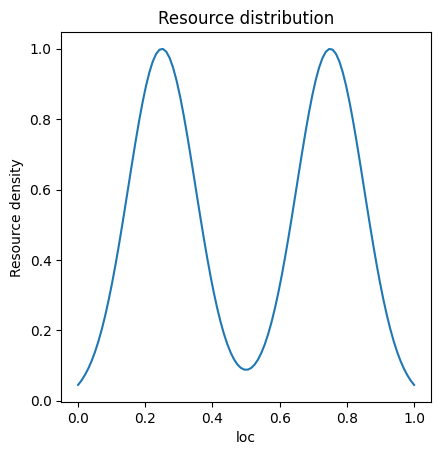

In [2]:
#The resource points
bin_points=np.linspace(.001, .999, 100)
 
#Resource parameters
resource_parameters_gaussian=[[.1,.1],[.25,.75],[1,1]] #[[sd1, sd2,], [mean1,mean2], [factor1,factor2]]
#Resource distribution
resource_distribution2=rd.resource_distribution_choice(bin_points=bin_points,resource_type='multi_modal_gaussian_distribution_1D',resource_parameters=resource_parameters_gaussian)

#Plot
domain=bin_points
fig, ax = plt.subplots()
ax.plot(domain,resource_distribution2)
plt.title('Resource distribution')
plt.xlabel('loc')
plt.ylabel('Resource density')
ax.set_box_aspect(1) 
#fig.savefig('1d_bimodal_alpha_05.svg',bbox_inches='tight')
plt.show()


## Setup:The enviroment and adapative enviroment

The cell below sets up the outer shell for visualizing the the adapative enviroment. 

In [3]:
domain_type='1d'
resource_distribution=resource_distribution2
mean=np.dot(bin_points,resource_distribution)/np.sum(resource_distribution) #mean of the resource distribution

num_agents=2 #number of agents
int_agents_pos=general.agent_position_setup(num_agents=num_agents,setup_type='paper_default',domain_type=domain_type,domain_bounds=0)

infl_configs={"infl_type":"gaussian"} # infleunce type of the agents

parameters=general.agent_parameter_setup(num_agents=num_agents,infl_type=infl_configs["infl_type"],setup_type="initial_symmetric_setup",reach=.14) # parmameters impacting agents reach (their std)
#parameters_custom=np.array([[.1,.2,.3,...]]) #needs to be length num_players

lr_type='cosine'
learning_rate=[1/10000,1/10000,500] # learning rate parameters 
#lr_type='static'
#learning_rate=1/1000
time_steps=10000 # number steps for the adaptive dyanamics

R=.1
bin_torch=torch.tensor(bin_points).float()
cshift=torch.exp(-(0-bin_torch)**2/(2*R**2))+torch.exp(-(1-bin_torch)**2/(2*R**2))
cshift = cshift.unsqueeze(0) 

vis=Shell(num_agents=num_agents,agents_pos=int_agents_pos,parameters=parameters,resource_distribution=resource_distribution,bin_points=bin_points, 
        infl_configs = {'infl_type': 'gaussian'}, learning_rate_type= 'cosine_annealing', learning_rate= [.0001, .0001, 15], time_steps=time_steps,
        fp= 0, infl_cshift= True, cshift = cshift, infl_fshift= True, Q = 25,
        domain_type = '1d', domain_bounds = [0, 1], resource_type = 'na', domain_refinement = 10,
        tolerance = 10**-8, tolerated_agents = None,ignore_zero_infl= True)


vis.setup_adaptive_env()
vis.field.gradient_ascent()
og_pos_matrix=vis.field.pos_matrix
og_grad_matrix=vis.field.grad_matrix
vis.agents_pos=int_agents_pos.clone()
vis.field.agents_pos=int_agents_pos.clone()

Probability from each influence kernel

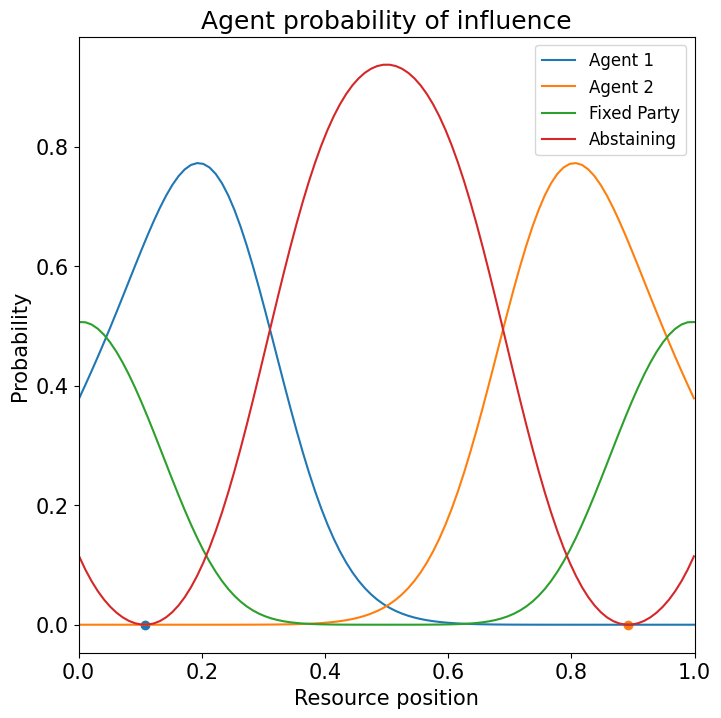

In [4]:
vis.prob_plot(position=vis.field.pos_matrix[0],save=True,name_ads=['3p_ab'],paper_figure={'paper': True, 'section': '5_1','figure_id': 'fig9'})

## End State plot

Shows the players influence over the resource distribution as they move via adaptive dynamics

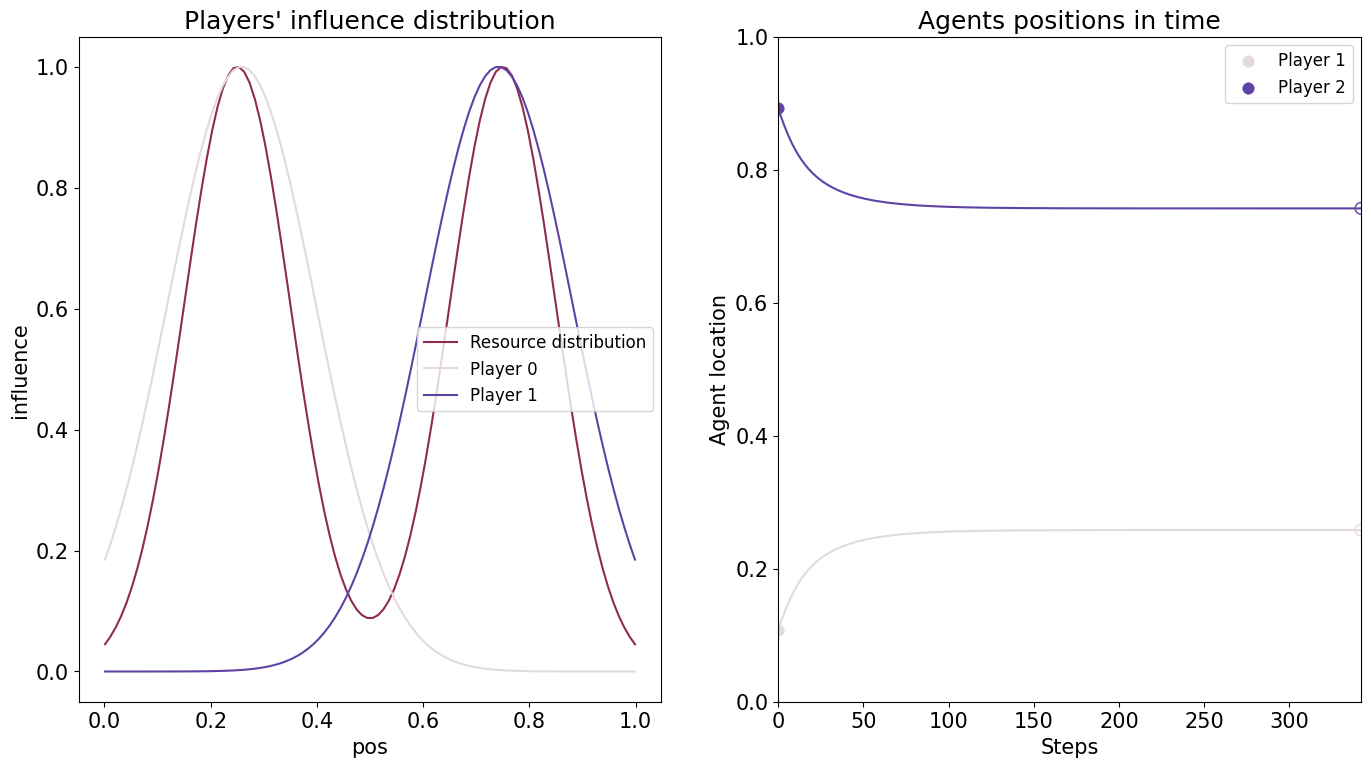

In [5]:
vis.dist_pos_gif(1)

## Gif State plot

gif of the above plot

In [6]:
#vis.dist_pos_gif(100)

## Gradient Plot
Plots the agents gradient as they move using adaptive dynamics

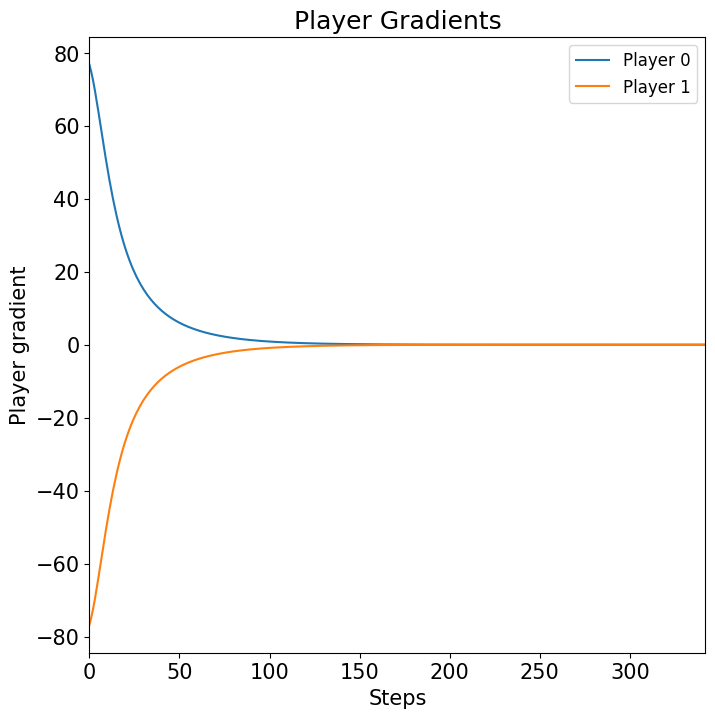

In [7]:
vis.grad_plot()

## Gradient vector plot for 2 agents (this is a face of the gradient vector space)

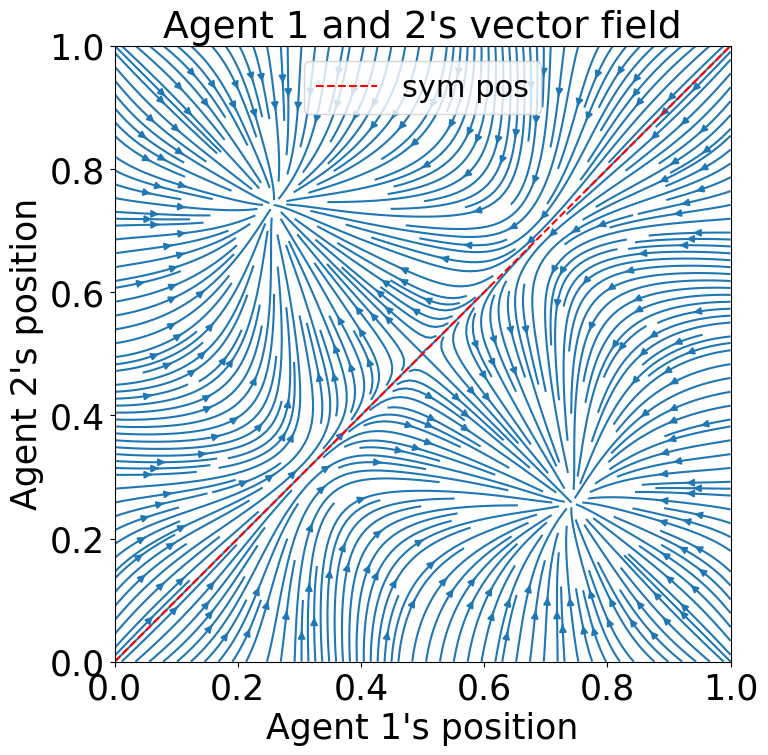

In [8]:
vis.vect_plot(agent_id=0,
              parameter_instance=vis.field.parameters,
              density=3,
              save=True,
              name_ads=['3p_ab'],
              paper_figure={'paper': True, 'section': '5_1','figure_id': 'fig9'},
              font={'default_size': 25, 'cbar_size': 22, 'title_size': 27, 'legend_size': 22, 'font_family': 'sans-serif'})

## Equalibirium bifirications as we cahnge the reach parameters ($\alpha$=0.5)

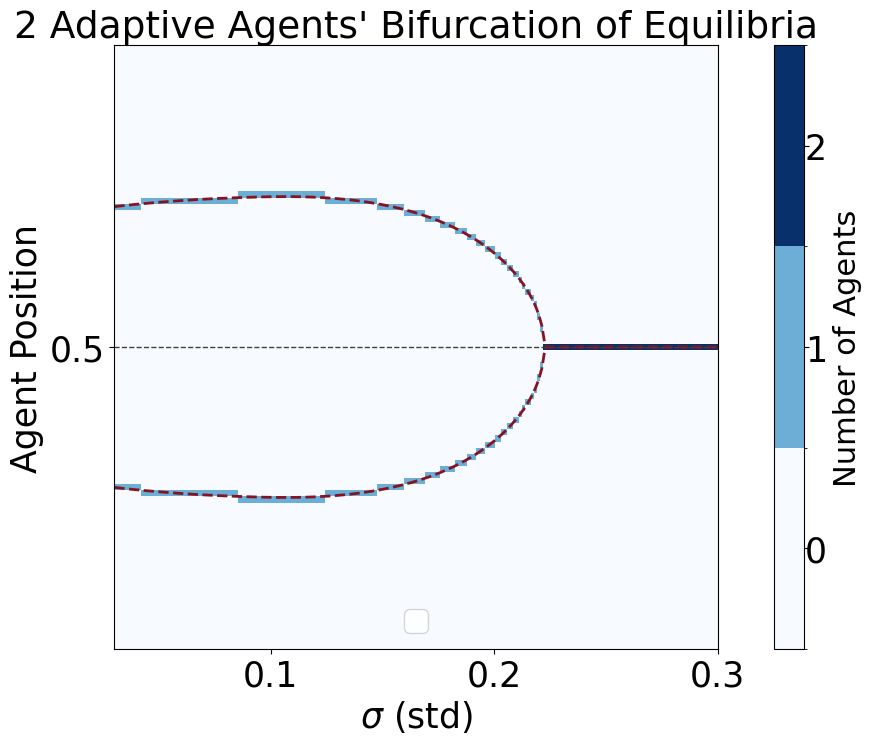

In [9]:
fig=vis.equilibrium_bifurcation_plot(reach_start=.03,
                                        reach_end=.3,
                                        reach_num_points=200,
                                        time_steps=10000,
                                        initial_pos=vis.agents_pos,
                                        plot_type="heat",
                                        name_ads=['3p_ab'],
                                        title_ads=[],
                                        refinements=10,
                                        parallel_configs={'parallel':True, 'max_workers':8, 'batch_size':4},
                                        font={'default_size': 25, 'cbar_size': 22, 'title_size': 27, 'legend_size': 22, 'font_family': 'sans-serif'},
                                        cbar_config={'center_labels': True, 'label_alignment': 'center', 'shrink': 1.0},
                                        save=True,
                                        paper_figure={'paper': True, 'section': '5_1','figure_id':'fig10'})
vis.field.pos_matrix=og_pos_matrix
vis.field.grad_matrix=og_grad_matrix
fig